In [4]:
import os
import time
from operator import itemgetter  # used for sorting

import altair as alt
import pandas as pd  # makes manipulating the data easier
import requests
from IPython.display import clear_output
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm.auto import tqdm

# Make sure data directory exists
os.makedirs("docs", exist_ok=True)

# Create a session that will automatically retry on server errors
s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[502, 503, 504])
s.mount("http://", HTTPAdapter(max_retries=retries))
s.mount("https://", HTTPAdapter(max_retries=retries))
# %%capture
# Load variables from the .env file if it exists
# Use %%capture to suppress messages
# %load_ext dotenv
# %dotenv
# Enter a Trove API key
# We're going to get our data from the Trove API. You'll need to get your own Trove API key and enter it below.

# Insert your Trove API key
API_KEY = "EbpPt36xvAqN8d6F46B1oQWI3BULYecZ"

# Use api key value from environment variables if it is available
if os.getenv("TROVE_API_KEY"):
    API_KEY = os.getenv("TROVE_API_KEY")
# Set some default parameters
# Basic parameters to send to the Trove API, we'll add more later.
params = {
    "zone": "newspaper",
    "key": API_KEY,
    "encoding": "json",
    "n": 0,  # We don't need any records, just the facets!
}
# Define some functions
def get_results(params):
    """
    Get JSON response data from the Trove API.
    Parameters:
        params
    Returns:
        JSON formatted response data from Trove API
    """
    response = s.get(
        "https://api.trove.nla.gov.au/v2/result", params=params, timeout=30
    )
    response.raise_for_status()
    # print(response.url) # This shows us the url that's sent to the API
    data = response.json()
    return data
# 2. Show the total number of articles per year
# In another notebook, I look at different ways of visualising Trove newspaper searches over time. In this notebook we're going to focus on showing everything. To search for everything, we set the q parameter to a single space.

# Set the q parameter to a single space to get ALL THE ARTICLES
params["q"] = " "
#Now we can find the total number of newspaper articles in Trove.

# Get the JSON data from the Trove API using our parameters
data = get_results(params)

# Navigate down the JSON hierarchy to find the total results
total = int(data["response"]["zone"][0]["records"]["total"])

# Print the results
print("There are currently {:,} articles in Trove!".format(total))
# There are currently 233,666,567 articles in Trove!
# Ok, that's not all that useful. What would be more interesting is to show the total number of articles published each year. To do this we use the decade and year facets. There's more details in this notebook but, in short, we have to loop through the decades from 1800 to 2010, getting the total number of articles for each year within that decade.

# These two functions do just that.

def get_facets(data):
    """
    Loop through facets in Trove API response, saving terms and counts.
    Parameters:
        data  - JSON formatted response data from Trove API
    Returns:
        A list of dictionaries containing: 'term', 'total_results'
    """
    facets = []
    try:
        # The facets are buried a fair way down in the results
        # Note that if you ask for more than one facet, you'll have use the facet['name'] param to find the one you want
        # In this case there's only one facet, so we can just grab the list of terms (which are in fact the results by year)
        for term in data["response"]["zone"][0]["facets"]["facet"]["term"]:

            # Get the year and the number of results, and convert them to integers, before adding to our results
            facets.append({"term": term["search"], "total_results": int(term["count"])})

        # Sort facets by year
        facets.sort(key=itemgetter("term"))
    except TypeError:
        pass
    return facets


def get_facet_data(params, start_decade=180, end_decade=201):
    """
    Loop throught the decades from 'start_decade' to 'end_decade',
    getting the number of search results for each year from the year facet.
    Combine all the results into a single list.
    Parameters:
        params - parameters to send to the API
        start_decade
        end_decade
    Returns:
        A list of dictionaries containing 'year', 'total_results' for the complete
        period between the start and end decades.
    """
    # Create a list to hold the facets data
    facet_data = []

    # Loop through the decades
    for decade in tqdm(range(start_decade, end_decade + 1)):

        # Avoid confusion by copying the params before we change anything.
        search_params = params.copy()

        # Add decade value to params
        search_params["l-decade"] = decade

        # Get the data from the API
        data = get_results(search_params)

        # Get the facets from the data and add to facets_data
        facet_data += get_facets(data)

        # Try to avoid hitting the API rate limit - increase this if you get 403 errors
        time.sleep(0.2)

    # Reomve the progress bar (you can also set leave=False in tqdm, but that still leaves white space in Jupyter Lab)
    clear_output()
    return facet_data
# Next we need to tell the API we want the year facet values. We do this by setting the facet value in our parameters.

params["facet"] = "year"
# Now it's just a matter of feeding our parameters to the get_facet_data() function.

total_facets = get_facet_data(params)
# Let's convert the data to a Pandas dataframe so we can feed it to Altair, our charting program.

df_total = pd.DataFrame(total_facets)
df_total.head()

,term,total_results
0,1803,526
1,1804,619
2,1805,430
3,1806,367
4,1807,134


In [5]:
# Feed Altair our dataframe
alt.Chart(df_total).mark_line(point=True).encode(
    # Years along the X axis
    x=alt.X("term:Q", axis=alt.Axis(format="c", title="Year")),
    # Number of articles on the Y axis (formatted with thousands separators)
    y=alt.Y("total_results:Q", axis=alt.Axis(format=",d", title="Number of articles")),
    # Use tooltips to display the year and number of articles when you hover over a point
    tooltip=[
        alt.Tooltip("term:Q", title="Year"),
        alt.Tooltip("total_results:Q", title="Articles", format=","),
    ],
).properties(width=700, height=400)

alt.Chart(...)

In [7]:
newspaper_data = pd.read_csv("manually-selected-newspaper-chinese-recipes-labelled.csv")
yearly_counts = newspaper_data.groupby('year').size().reset_index(name='total_entries')
yearly_counts.head()

,year,total_entries
0,1870,1
1,1883,1
2,1890,1
3,1893,1
4,1894,2


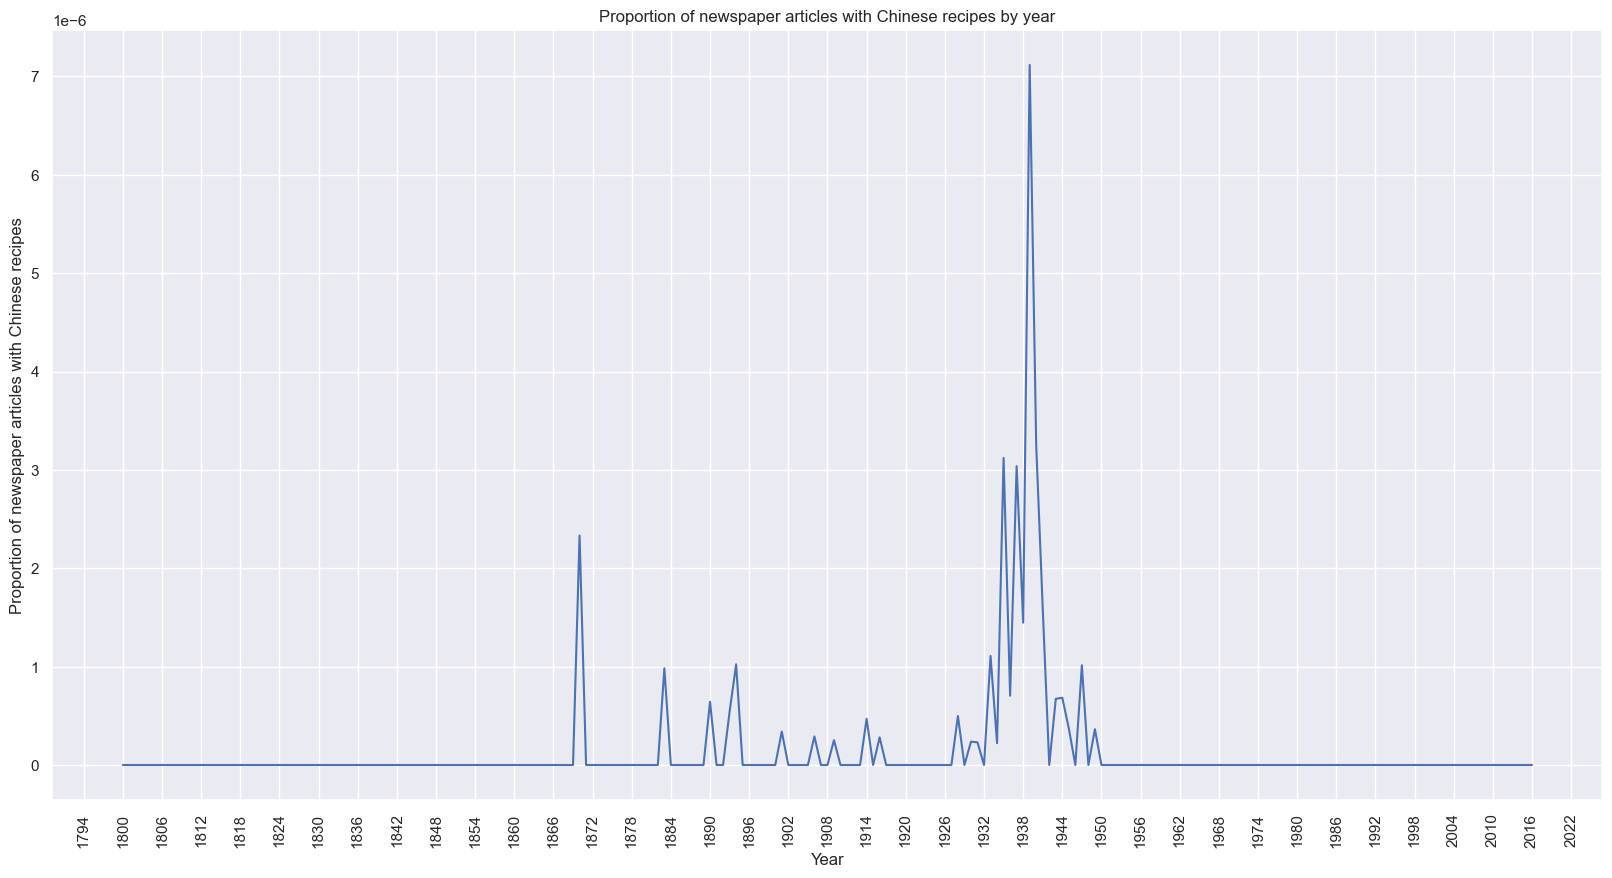

In [35]:
# fill in missing years
yearly_counts = yearly_counts.set_index('year').reindex(range(1800, 2020), fill_value=0).rename_axis('year').reset_index()

yearly_counts['total_entries'] = yearly_counts['total_entries'].astype(int)
yearly_counts['total_results'] = df_total['total_results'].astype(int)
yearly_counts['proportion'] = yearly_counts['total_entries'] / yearly_counts['total_results']

# plot a line plot of proportion in yearly_counts by year with matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(20,10))
plt.plot(yearly_counts['year'], yearly_counts['proportion'])
plt.xlabel('Year')
plt.ylabel('Proportion of newspaper articles with Chinese recipes')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=len(yearly_counts['year'])//5, prune='both'))

plt.xticks(rotation=90)
plt.title('Proportion of newspaper articles with Chinese recipes by year')
plt.show()


